## Imports and Load Datasets

In [5]:
# std
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import os
import re
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor

# img viz
import matplotlib.pyplot as plt
import seaborn as sns

# img proc
import cv2
from skimage import color, io

# ml
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# tensorflow
import tensorflow as tf

# torch
import torch
from torch import nn
from torch.optim import Adam
import torch.nn.functional as F
import torchvision
from torchvision.io import read_image, ImageReadMode
from torch.utils.data import Dataset, DataLoader

# progress bar
from tqdm import tqdm

In [4]:
class PlantDataset(Dataset):
  """Load images as needed. Directory must be placed as: datadir/split/category/*.png"""
  def __init__(self,
                datadir='/content/drive/MyDrive/281 Computer Vision Summer 2023/Tomato Leaf Disease Classification/final_dataset',
                split='train',
                fmt='np'):
      # store image list from disk
      self.im_paths = sorted(glob.glob(os.path.join(datadir, split, '**/*.png')))
      # store the labels and create lookup for easy retrieval
      self.lbl_list = list(map(lambda lbl: lbl.split(os.path.sep)[-2].lower(), self.im_paths))
      self.lbl_cat_lkp = {e: i for i, e in enumerate(sorted(list(set(self.lbl_list))))}
      self.cat_lbl_lkp = {i: e for e, i in self.lbl_cat_lkp.items()}
      self.cat = np.array([self.lbl_cat_lkp[e] for e in self.lbl_list])
      self.fmt=fmt
      self.split=split

  def get_impath(self, idx): return self.im_paths[idx]

  def __getitem__(self, idx):
      """Return processed image from file list"""
      if self.fmt=='torch':
          im_path = self.im_paths[idx]
          tim = read_image(im_path, ImageReadMode.RGB)
          return tim/255, self.cat[idx]
      elif self.fmt=='np':
          im_path = self.im_paths[idx]
          npim = plt.imread(im_path)[..., :3] # remove alpha channel
          return npim, self.cat[idx]

  def __len__(self): return len(self.im_paths)

train_dset = PlantDataset()
print(f'>> Images on {train_dset.split}: {len(train_dset):,}')
print(pd.Series(train_dset.lbl_list).value_counts())

val_dset = PlantDataset(split='validation')
print(f'\n>> Images on {val_dset.split}: {len(val_dset):,}')
print(pd.Series(val_dset.lbl_list).value_counts())

test_dset = PlantDataset(split='test')
print(f'\n>> Images on {test_dset.split}: {len(test_dset):,}')
print(pd.Series(test_dset.lbl_list).value_counts())

print(f'\n>> Total images: {len(test_dset) + len(val_dset) + len(train_dset):,}')

>> Images on train: 14,523
tomato_yellow_leaf_curl_virus           4285
bacterial_spot                          1701
late_blight                             1527
septoria_leaf_spot                      1416
spider_mites_two-spotted_spider_mite    1340
healthy                                 1272
target_spot                             1123
early_blight                             800
leaf_mold                                761
tomato_mosaic_virus                      298
dtype: int64

>> Images on validation: 1,812
tomato_yellow_leaf_curl_virus           535
bacterial_spot                          212
late_blight                             190
septoria_leaf_spot                      177
spider_mites_two-spotted_spider_mite    167
healthy                                 159
target_spot                             140
early_blight                            100
leaf_mold                                95
tomato_mosaic_virus                      37
dtype: int64

>> Images on test: 1,824

## Gray World/Green World
1. One simple technique for white balancing is based on the gray-world assumption. This assumption argues that the average reflectance of a scene is achromatic. In other words, the mean of the red, green, and blue channels in a given scene should be roughly equal. We will implement this white balancing technique. Write a function to automatically white balance an image using the gray-world assumption. You should multiply each color channel by a scale factor so that the resulting mean of each of the three color channels is the same and equal to the average value of the green channel of the input image.

In [23]:
def calc_avg_rgb(dataset):
    red_total = 0
    green_total = 0
    blue_total = 0
    for img, _ in tqdm(dataset):
        # get avg rgb ratio for current image
        avg_red_val = np.mean(img[:,:,0])
        avg_green_val = np.mean(img[:,:,1])
        avg_blue_val = np.mean(img[:,:,2])
        # add rgb to running sum
        red_total = red_total + avg_red_val
        green_total = green_total + avg_green_val
        blue_total = blue_total + avg_blue_val
    # get average rgb of entire dataset
    total_imgs = len(dataset)
    avg_red = red_total/total_imgs
    avg_green = green_total/total_imgs
    avg_blue = blue_total/total_imgs
    return avg_red, avg_green, avg_blue

def apply_green_world(dataset, avg_red, avg_green, avg_blue):
    corrected_imgs = []
    for img, _ in tqdm(dataset):
        # get average red, green and blue values
        avg_red_val = np.mean(img[:,:,0])
        avg_green_val = np.mean(img[:,:,1])
        avg_blue_val = np.mean(img[:,:,2])
        # compute scale factor for red and blue
        red_scale_factor = 1.0/avg_red_val
        green_scale_factor = 1.0/avg_green_val
        blue_scale_factor = 1.0/avg_blue_val
        # rescale red, green and blue channels
        wb_img = img.copy()
        wb_img[:,:,0] = wb_img[:,:,0] * red_scale_factor
        wb_img[:,:,1] = wb_img[:,:,1] * green_scale_factor
        wb_img[:,:,2] = wb_img[:,:,2] * blue_scale_factor
        corrected_imgs.append(wb_img)
    return corrected_imgs

In [31]:
# create smaller train dataset, took 2m 26s to run
train_dset_small = []
size = 1000
i = 0
while i < size:
    train_dset_small.append(train_dset[i])
    i = i + 1

In [33]:
img, label = train_dset_small[0]

In [34]:
label

0

In [35]:
print('Train')
train_avg_red, train_avg_green, train_avg_blue = calc_avg_rgb(train_dset_small)
print("train_avg_red: ", train_avg_red)
print("train_avg_green: ", train_avg_green)
print("train_avg_blue: ", train_avg_blue)
white_balanced_train_imgs = apply_green_world(train_dset_small, train_avg_red, train_avg_green, train_avg_blue)

Train



100%|██████████| 1000/1000 [00:00<00:00, 2683.39it/s]


train_avg_red:  0.15235288085788487
train_avg_green:  0.20955443170666693
train_avg_blue:  0.14462511143274606



100%|██████████| 1000/1000 [00:02<00:00, 492.81it/s]


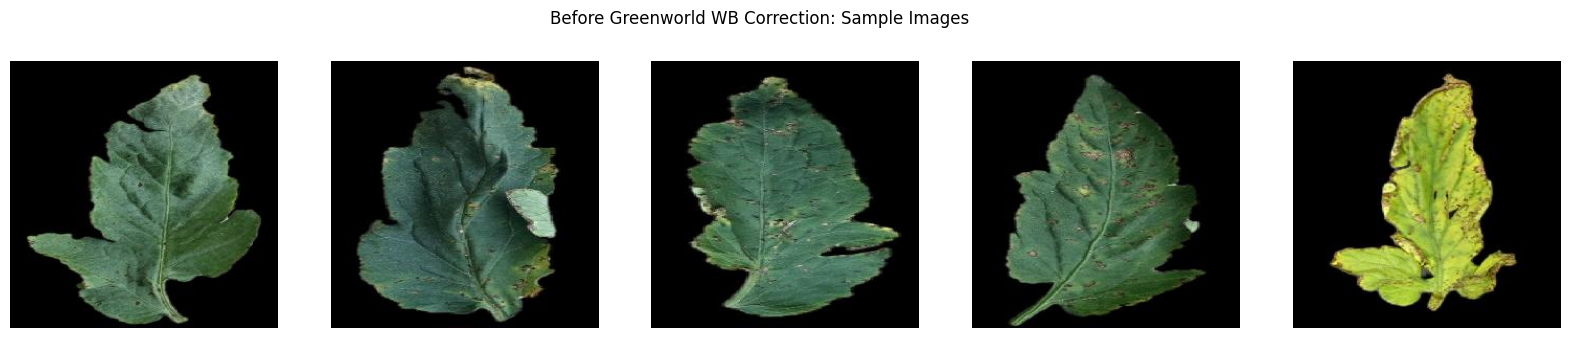

In [48]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
fig.suptitle("Before Greenworld WB Correction: Sample Images", y=0.68)
ax[0].imshow(train_dset_small[0][0])
ax[0].axis('off')
ax[1].imshow(train_dset_small[1][0])
ax[1].axis('off')
ax[2].imshow(train_dset_small[2][0])
ax[2].axis('off')
ax[3].imshow(train_dset_small[3][0])
ax[3].axis('off')
ax[4].imshow(train_dset_small[4][0])
ax[4].axis('off')
plt.show()

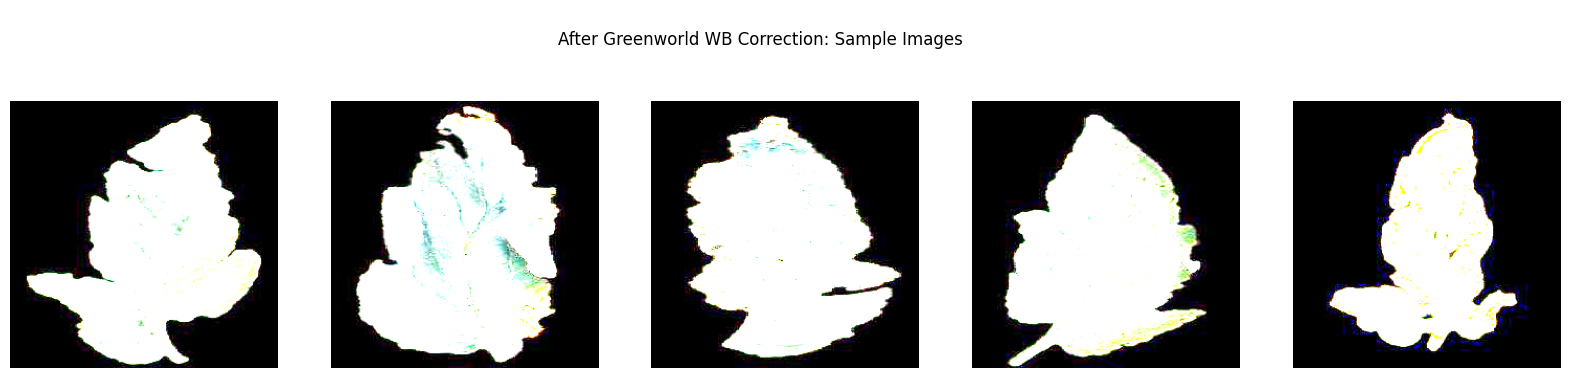

In [53]:
fig, ax = plt.subplots(1, 5, figsize=(20, 10))
fig.suptitle("\nAfter Greenworld WB Correction: Sample Images", y=0.72)
ax[0].imshow(white_balanced_train_imgs[0])
ax[0].axis('off')
ax[1].imshow(white_balanced_train_imgs[1])
ax[1].axis('off')
ax[2].imshow(white_balanced_train_imgs[2])
ax[2].axis('off')
ax[3].imshow(white_balanced_train_imgs[3])
ax[3].axis('off')
ax[4].imshow(white_balanced_train_imgs[4])
ax[4].axis('off')
plt.show()